In [1]:
import numpy as np
import cv2 as cv
from PIL import Image, ImageEnhance
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib .pyplot as plt
from itertools import permutations
import os
import random

In [2]:
def scale(x, scalar):
    height = int(x.size[0] * scalar)
    width = int(x.size[1] * scalar)
    dim = (width, height)
    return x.resize(dim)

def rotate(x, degree):
    # Rotate the image by degrees counter clockwise
    return x.rotate(degree)

def enh_bri(x, brightness):
    bri = ImageEnhance.Brightness(x)
    return bri.enhance(brightness)

def enh_con(x, contrast):
    con = ImageEnhance.Contrast(x)
    return con.enhance(contrast)

def enh_sha(x, sharpness):
    sha = ImageEnhance.Sharpness(x)
    return sha.enhance(sharpness)

def gaussian(x, kernel_size):
    x = np.array(x)
    x = cv.GaussianBlur(x, kernel_size, sigmaX=0)
    return Image.fromarray(x)

def shear(x, shear_factor):
    # 定义错切变换矩阵
    shear_matrix = [1, shear_factor, 0, 0, 1, 0]

    # 创建Affine对象并应用错切变换
    sheared_img = x.transform(
        x.size, Image.Transform.AFFINE, shear_matrix
    )
    return sheared_img

def translate(x, shift):
    shift_x, shift_y = shift[0], shift[1]
    # 进行平移操作
    translated_img = x.transform(
        x.size, Image.Transform.AFFINE, (1, 0, shift_x, 0, 1, shift_y)
    )
    return translated_img

mrs = [rotate, enh_bri, enh_sha, enh_con, gaussian, shear, translate]
mrs_name =[mr.__name__ for mr in mrs]
print(mrs_name)
paras = [3, 0.8, 0.8, 0.8, (3, 3), 0.1, (1,1)]



['rotate', 'enh_bri', 'enh_sha', 'enh_con', 'gaussian', 'shear', 'translate']


In [3]:
class CustomDataset(Dataset):
    def __init__(self, dataset, cmr=None, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []
        for idx, (img, label) in enumerate(dataset):
            if cmr is not None:
                for index in cmr:
                    img = mrs[index](img, paras[index])
            self.data.append(img)
            self.labels.append(label)
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data, label = self.data[idx], self.labels[idx]
        if self.transform is not None:
            data = self.transform(data)
        return data, label

In [ ]:
# 设置随机种子
torch.manual_seed(18)

#transform = models.DenseNet121_Weights.IMAGENET1K_V1.transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3), # the mode of some images is L not RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载 Caltech-256 数据集
caltech256_dataset = datasets.Caltech256(root='data', download=True)

 
X = [caltech256_dataset[i][0] for i in range(len(caltech256_dataset))]
y = [caltech256_dataset[i][1] for i in range(len(caltech256_dataset))]

# X = []
# y = []
# for i in range(len(caltech256_dataset)):
#     if caltech256_dataset[i][1]!=256:
#         X.append(caltech256_dataset[i][0])
#         y.append(caltech256_dataset[i][1])
# print(len(X))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=18, stratify=y)

train_set = CustomDataset(zip(X_train, y_train), transform=transform)
test_set = CustomDataset(zip(X_test, y_test), transform=transform)

# for i in range(len(train_set)):
#     print(type(train_set[i][0]))

batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


# 构建 DenseNet 模型
densenet = models.densenet121(weights='DEFAULT')  # 使用预训练的 DenseNet-121 模型
# 修改最后的全连接层以适应 Caltech-256 数据集的输出类别数量
num_classes = 257  # 注意类别数量可能需要根据实际情况进行调整
densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)



# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=0.001)

# 模型训练
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet.to(device)
print(device)

densenet.train()  # 设置模型为训练模式
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = densenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {running_loss/len(train_loader)}")

# 测试模型
densenet.eval()  # 设置模型为评估模式
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = densenet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {(100 * correct / total):.2f}%")

In [ ]:
model_name = 'DenseNet121_6838'
torch.save(densenet.state_dict(),'./models/'+model_name+'.pth')

In [4]:
# 设置随机种子
torch.manual_seed(18)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#transform = models.DenseNet121_Weights.IMAGENET1K_V1.transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3), # the mode of some images is L not RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载 Caltech-256 数据集
caltech256_dataset = datasets.Caltech256(root='data', download=True)

 
X = [caltech256_dataset[i][0] for i in range(len(caltech256_dataset))]
y = [caltech256_dataset[i][1] for i in range(len(caltech256_dataset))]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=18, stratify=y)

train_set = CustomDataset(zip(X_train, y_train), transform=transform)
test_set = CustomDataset(zip(X_test, y_test), transform=transform)


batch_size = 2
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model_name = 'DenseNet121_6838'
model = models.densenet121(weights='DEFAULT')  # 使用预训练的 DenseNet-121 模型
# 修改最后的全连接层以适应 Caltech-256 数据集的输出类别数量
num_classes = 257  # 注意类别数量可能需要根据实际情况进行调整
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.load_state_dict(torch.load('./models/'+model_name+'.pth'))

model.eval()
model.to(device)
correct = 0
total = 0
pred_source = np.zeros(len(X_test),dtype=int)
with torch.no_grad():
    for i,(X,y) in enumerate(test_loader):
        X,y = X.to(device),y.to(device)
        outputs = model(X)
        _, pred = torch.max(outputs, 1)
        pred_source[i*batch_size:i*batch_size+X.size(0)] = pred.cpu()
        correct += (pred==y).sum().item()
        total += y.size(0)

accuracy = correct/total
print(accuracy)

np.save('predictions/'+model_name+'_source.npy', pred_source)

Files already downloaded and verified
0.6837634759882392


In [4]:
torch.manual_seed(18)

model_name = 'DenseNet121_6838'
model = models.densenet121()
num_classes = 257  # 注意类别数量可能需要根据实际情况进行调整
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.load_state_dict(torch.load('./models/'+model_name+'.pth'))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

batch_size = 1024

# 数据集根目录和预处理
root_dir = '/path/to/caltech256'
#transform = models.DenseNet121_Weights.IMAGENET1K_V1.transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3), # the mode of some images is L not RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载 Caltech-256 数据集
caltech256_dataset = datasets.Caltech256(root='data', download=True)

 
X = [caltech256_dataset[i][0] for i in range(len(caltech256_dataset))]
y = [caltech256_dataset[i][1] for i in range(len(caltech256_dataset))]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=18, stratify=y)
test_set = CustomDataset(zip(X_test, y_test))

pred_followup = {}
for k in range(len(mrs)): 
    k = k+1
    for p in permutations(range(len(mrs)), k):
        if p in pred_followup.keys():
            continue
        print(p)
        temp = np.zeros(len(test_set), dtype=int)
        dateset_followup = CustomDataset(test_set, cmr=p, transform=transform)
        testload_followup = torch.utils.data.DataLoader(dateset_followup, batch_size=batch_size, shuffle=False)
        with torch.no_grad():
            for i,(X,y) in enumerate(testload_followup):
                X = X.to(device)
                outputs = model(X)
                _, pred = torch.max(outputs, 1)
                temp[i*batch_size:i*batch_size+X.size(0)] = pred.cpu()
        pred_followup[p] = temp

Files already downloaded and verified
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(1, 0)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(2, 0)
(2, 1)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(3, 0)
(3, 1)
(3, 2)
(3, 4)
(3, 5)
(3, 6)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 5)
(4, 6)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 6)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 2, 1)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 3, 1)
(0, 3, 2)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 4, 1)
(0, 4, 2)
(0, 4, 3)
(0, 4, 5)
(0, 4, 6)
(0, 5, 1)
(0, 5, 2)
(0, 5, 3)
(0, 5, 4)
(0, 5, 6)
(0, 6, 1)
(0, 6, 2)
(0, 6, 3)
(0, 6, 4)
(0, 6, 5)
(1, 0, 2)
(1, 0, 3)
(1, 0, 4)
(1, 0, 5)
(1, 0, 6)
(1, 2, 0)
(1, 2, 3)
(1, 2, 4)
(1, 2, 5)
(1, 2, 6)
(1, 3, 0)
(1, 3, 2)
(1, 3, 4)
(1, 3, 5)
(1, 3, 6)
(1, 4, 0)
(1, 4, 2)
(1, 4, 3)
(1, 4, 5)
(1, 4, 6)
(1, 5, 0)
(1, 5, 2)
(1, 5, 3)
(1, 5, 4)
(1, 5, 6)
(1, 6, 0)
(1, 6, 2)
(1, 6, 3)
(1, 6, 4)
(1, 6, 5)
(2, 0, 1)
(2, 0, 3)
(2, 0, 4)
(2,

In [5]:
np.save('predictions/'+model_name.split('.')[0]+'_followup.npy', pred_followup)

Files already downloaded and verified


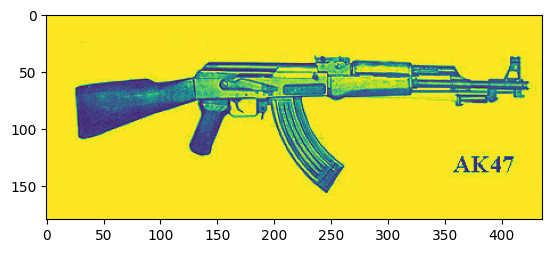

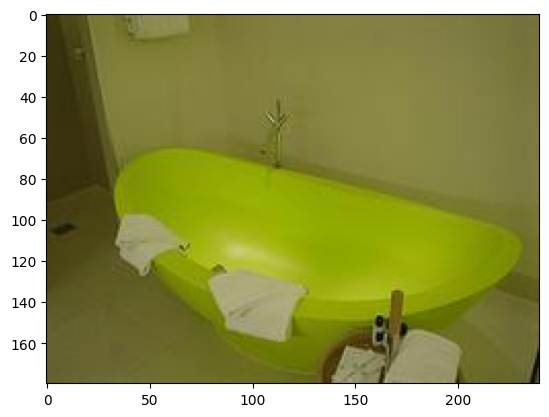

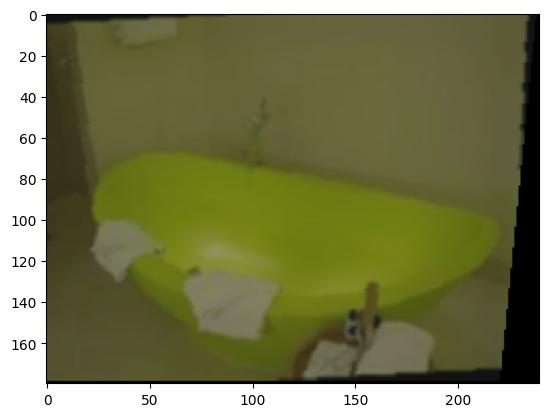

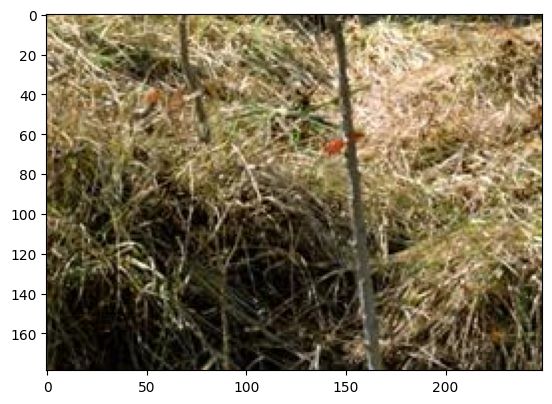

256


In [14]:
caltech256_dataset = datasets.Caltech256(root='data', download=True)

plt.imshow(caltech256_dataset[15][0])
plt.show()

x = caltech256_dataset[1001][0]
plt.imshow(x)
plt.show()
for i in range(len(mrs)):
    x = mrs[i](x, paras[i])
plt.imshow(x)
plt.show()

plt.imshow(caltech256_dataset[-1][0])
plt.show()

print(caltech256_dataset[-1][1])

In [ ]:
for i in range(len(X)):
    print(i)
    transform(X[i])

In [ ]:
a = zip([2,3],[0,1])

for ide, (x,y) in enumerate(a):
    print(x,y)

In [ ]:
from PIL import Image
import cv2 as cv
import numpy as np
from torchvision import datasets
import matplotlib.pyplot as plt

from PIL import ImageChops

def compare_images(img1, img2):
    print(type(img1), type(img2), img1.size, img2.size, img1.mode, img2.mode)
    if img1.size != img2.size:
        return False
    diff = ImageChops.difference(img1, img2)
    if diff.getbbox() is None:
        # 图像相同
        return True
    else:
        # 图像不同
        return False

def gaussian(x, kernel_size):
    x = np.array(x)
    x = cv.blur(x, kernel_size)
    return Image.fromarray(x)

def gaussian_new(x, kernel_size):
    x = np.array(x)
    x = cv.cvtColor(x, cv.COLOR_BGR2RGB)
    x = cv.blur(x, kernel_size)
    x = cv.cvtColor(x, cv.COLOR_RGB2BGR)
    return Image.fromarray(x)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True)
x = mnist_testset[0][0]

plt.imshow(x)

y = gaussian(x,(1,1))
for i in range(100):
    x = mnist_testset[i][0]
    print(x==gaussian(x,(1,1)), x==gaussian_new(x,(1,1)))
    print(compare_images(x,gaussian(x,(1,1))))
    print(compare_images(x,gaussian_new(x,(1,1))))

In [ ]:
image = Image.open('airplane.png')
plt.imshow(image)


In [ ]:
image_g = gaussian(image,(1,1))
plt.imshow(image_g)
print(image==image_g)
print(compare_images(image, image_g))

In [ ]:
image_gn = gaussian_new(image,(1,1))
plt.imshow(image_gn)

In [ ]:
x = Image.open('airplane.png')
print(x==gaussian(x,(1,1)), compare_images(x, gaussian(x,(1,1))))
x = Image.open('airplane.png')   
print(x==gaussian_new(x,(1,1)), compare_images(x, gaussian_new(x,(1,1))))

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, cmr=None, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []
        for idx, (img, label) in enumerate(dataset):
            if cmr is not None:
                for index in cmr:
                    img = mrs[index](img, paras[index])
            self.data.append(img)
            self.labels.append(label)
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform is not None:
            self.data[idx] = self.transform(self.data[idx])
        return self.data[idx], self.labels[idx]
    
# 设置随机种子
torch.manual_seed(18)

# 数据集根目录和预处理
root_dir = '/path/to/caltech256'
#transform = models.DenseNet121_Weights.IMAGENET1K_V1.transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3), # the mode of some images is L not RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载 Caltech-256 数据集
caltech256_dataset = datasets.Caltech256(root='data', download=True)

X = [caltech256_dataset[i][0] for i in range(len(caltech256_dataset))]
y = [caltech256_dataset[i][1] for i in range(len(caltech256_dataset))]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=28, stratify=y)

train_set = CustomDataset(zip(X_train, y_train), transform=transform)
test_set = CustomDataset(zip(X_test, y_test), transform=transform)

# for i in range(len(train_set)):
#     print(type(train_set[i][0]))

batch_size = 8
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


# 构建 DenseNet 模型
densenet = models.densenet121(weights='DEFAULT')  # 使用预训练的 DenseNet-121 模型

# 修改最后的全连接层以适应 Caltech-256 数据集的输出类别数量
num_classes = 257  # 注意类别数量可能需要根据实际情况进行调整
densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=0.001)

# 模型训练
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet.to(device)
print(device)

densenet.train()  # 设置模型为训练模式
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        print(1)
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = densenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {running_loss/len(train_loader)}")

# 测试模型
densenet.eval()  # 设置模型为评估模式
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = densenet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {(100 * correct / total):.2f}%")

In [24]:
import torch

torch.cuda.empty_cache()
